In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecg50000/ECG5000_TEST.ts
/kaggle/input/ecg50000/ECG5000_TRAIN.ts
/kaggle/input/ecg50000/ECG5000_TRAIN.txt
/kaggle/input/ecg50000/ECG5000_TRAIN.arff
/kaggle/input/ecg50000/ECG5000.txt
/kaggle/input/ecg50000/ECG5000_TEST.txt
/kaggle/input/ecg50000/ECG5000_TEST.arff


# Preprocessing

In [2]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 13.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tslearn.datasets import UCR_UEA_datasets # Correct import
from sklearn.model_selection import train_test_split # New import for splitting
import scipy.fft as fft
import random

# --- 0. Set Random Seeds for Reproducibility ---
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# --- 1. Define Dataset Paths (Kaggle specific, optional) ---
KAGGLE_INPUT_PATH = "/kaggle/input/ecg50000/"
DATASET_NAME = "ECG5000"

# --- 2. Load Data using tslearn (this will load the default UCR train/test splits) ---
dataset_loader = UCR_UEA_datasets()  # Instantiate the loader
X_train_raw_ucr, y_train_raw_ucr, X_test_raw_ucr, y_test_raw_ucr = dataset_loader.load_dataset(DATASET_NAME)

print(f"Original UCR X_train_raw shape: {X_train_raw_ucr.shape}")
print(f"Original UCR y_train_raw shape: {y_train_raw_ucr.shape}")
print(f"Original UCR X_test_raw shape: {X_test_raw_ucr.shape}")
print(f"Original UCR y_test_raw shape: {y_test_raw_ucr.shape}")

# Determine dataset characteristics from the combined data (before any new split)
NUM_CLASSES = len(np.unique(y_train_raw_ucr)) # Use train_raw_ucr to get all classes present
SEQUENCE_LENGTH = X_train_raw_ucr.shape[1]
NUM_CHANNELS = X_train_raw_ucr.shape[2] 

# Adjust labels if necessary (from 1-5 to 0-4 for PyTorch compatibility)
if np.min(y_train_raw_ucr) == 1:
    y_train_raw_ucr = y_train_raw_ucr - 1
    y_test_raw_ucr = y_test_raw_ucr - 1
    print("\nAdjusted labels to be 0-indexed (0-4).")

# --- 3. Combine original UCR train and test sets to form the *full* dataset for CondTSC ---
# This is our 'T' in the paper's context, i.e., the large dataset we want to condense from.
X_full = np.concatenate((X_train_raw_ucr, X_test_raw_ucr), axis=0)
y_full = np.concatenate((y_train_raw_ucr, y_test_raw_ucr), axis=0)

print(f"\nCombined Full Dataset (X_full) shape: {X_full.shape}") # Should be (5000, 140, 1)
print(f"Combined Full Dataset (y_full) shape: {y_full.shape}") # Should be (5000,)

Original UCR X_train_raw shape: (500, 140, 1)
Original UCR y_train_raw shape: (500,)
Original UCR X_test_raw shape: (4500, 140, 1)
Original UCR y_test_raw shape: (4500,)

Adjusted labels to be 0-indexed (0-4).

Combined Full Dataset (X_full) shape: (5000, 140, 1)
Combined Full Dataset (y_full) shape: (5000,)




# --- 4. Preprocessing ---

In [4]:

# We'll now split X_full/y_full into:
#   - X_cond_train, y_cond_train: This will be the 'T' (full training data) for the condensation process.
#     It's what CondTSC learns from.
#   - X_downstream_test, y_downstream_test: This will be the test set for *all* downstream model evaluations
#     (models trained on 'T' and models trained on condensed 'S').
#     This ensures models are evaluated on data they haven't seen during the condensation process.

# Choose a split ratio. For 5000 samples, 80% train / 20% test is common.
# stratify=y_full is crucial for imbalanced datasets like ECG5000 to maintain class distribution.
X_cond_train, X_downstream_test, y_cond_train, y_downstream_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=SEED, stratify=y_full
)

print(f"\nCondensation Training Data (T) shape: {X_cond_train.shape}")
print(f"Condensation Training Data (T) labels shape: {y_cond_train.shape}")
print(f"Downstream Test Data (T_test) shape: {X_downstream_test.shape}")
print(f"Downstream Test Data (T_test) labels shape: {y_downstream_test.shape}")

print(f"\nClass distribution in Condensation Training Data (T): {np.bincount(y_cond_train.astype(int))}")
print(f"Class distribution in Downstream Test Data (T_test): {np.bincount(y_downstream_test.astype(int))}")

# --- 5. Flatten for Scaler, then Standardize ---
# Scaler expects (N_samples, N_features). For time series, this means (N_samples, sequence_length * num_channels)
# Fit scaler ONLY on the condensation training data (X_cond_train)
X_cond_train_flat = X_cond_train.reshape(-1, SEQUENCE_LENGTH * NUM_CHANNELS)
X_downstream_test_flat = X_downstream_test.reshape(-1, SEQUENCE_LENGTH * NUM_CHANNELS)

scaler = StandardScaler()

# Fit only on condensation training data
X_cond_train_scaled_flat = scaler.fit_transform(X_cond_train_flat)
# Transform both train and test data using the *same* fitted scaler
X_downstream_test_scaled_flat = scaler.transform(X_downstream_test_flat)

print(f"\nScaled X_cond_train_flat shape: {X_cond_train_scaled_flat.shape}")
print(f"Scaled X_downstream_test_flat shape: {X_downstream_test_scaled_flat.shape}")

# --- 6. Reshape back to Time Series Format (N, L, C) ---
# For ECG5000: (N_samples, 140, 1)
X_cond_train_processed = X_cond_train_scaled_flat.reshape(-1, SEQUENCE_LENGTH, NUM_CHANNELS)
X_downstream_test_processed = X_downstream_test_scaled_flat.reshape(-1, SEQUENCE_LENGTH, NUM_CHANNELS)

print(f"Processed X_cond_train shape: {X_cond_train_processed.shape}")
print(f"Processed X_downstream_test shape: {X_downstream_test_processed.shape}")

# --- 7. Convert to PyTorch Tensors ---
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# These are the tensors you'll use throughout your CondTSC implementation
T_data_tensor = torch.tensor(X_cond_train_processed, dtype=torch.float32).to(device) # This is 'T' from paper
T_labels_tensor = torch.tensor(y_cond_train, dtype=torch.long).to(device)

Ttest_data_tensor = torch.tensor(X_downstream_test_processed, dtype=torch.float32).to(device) # This is 'Ttest' from paper
Ttest_labels_tensor = torch.tensor(y_downstream_test, dtype=torch.long).to(device)

print(f"T_data_tensor shape (for condensation): {T_data_tensor.shape}")
print(f"T_labels_tensor shape (for condensation): {T_labels_tensor.shape}")
print(f"Ttest_data_tensor shape (for downstream eval): {Ttest_data_tensor.shape}")
print(f"Ttest_labels_tensor shape (for downstream eval): {Ttest_labels_tensor.shape}")



Condensation Training Data (T) shape: (4000, 140, 1)
Condensation Training Data (T) labels shape: (4000,)
Downstream Test Data (T_test) shape: (1000, 140, 1)
Downstream Test Data (T_test) labels shape: (1000,)

Class distribution in Condensation Training Data (T): [2335 1414   77  155   19]
Class distribution in Downstream Test Data (T_test): [584 353  19  39   5]

Scaled X_cond_train_flat shape: (4000, 140)
Scaled X_downstream_test_flat shape: (1000, 140)
Processed X_cond_train shape: (4000, 140, 1)
Processed X_downstream_test shape: (1000, 140, 1)

Using device: cuda
T_data_tensor shape (for condensation): torch.Size([4000, 140, 1])
T_labels_tensor shape (for condensation): torch.Size([4000])
Ttest_data_tensor shape (for downstream eval): torch.Size([1000, 140, 1])
Ttest_labels_tensor shape (for downstream eval): torch.Size([1000])



# --- Synthetic Data Initialization (using KMeans ) ---

In [5]:

spc = 8 
synthetic_S_initial = []
synthetic_y_initial = []

for class_idx in range(NUM_CLASSES):
    class_data = T_data_tensor[T_labels_tensor == class_idx].cpu().numpy()
    if len(class_data) > 0:
        n_clusters_for_class = min(spc, len(class_data))
        if n_clusters_for_class == 0: continue
        kmeans = KMeans(n_clusters=n_clusters_for_class, random_state=SEED, n_init=10)
        kmeans.fit(class_data.reshape(len(class_data), -1))
        centroids = kmeans.cluster_centers_.reshape(n_clusters_for_class, SEQUENCE_LENGTH, NUM_CHANNELS)
        synthetic_S_initial.append(centroids)
        synthetic_y_initial.extend([class_idx] * n_clusters_for_class)

if synthetic_S_initial:
    S = torch.tensor(np.concatenate(synthetic_S_initial, axis=0), dtype=torch.float32).to(device)
    y_S = torch.tensor(synthetic_y_initial, dtype=torch.long).to(device)
    S.requires_grad = True
else:
    print("Warning: Synthetic data not initialized. Check data and spc.")


# model,augmentation,lossfn

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy.fft as fft
from copy import deepcopy
from tqdm.notebook import tqdm
# --- Define STFT Parameters ---
# For a sequence length of 140:
STFT_N_FFT = 64        # FFT window size. Common choices are powers of 2.
STFT_HOP_LENGTH = 16   # Hop length (stride) between successive windows.
STFT_WIN_LENGTH = 64   # Window length (usually same as n_fft).

# Calculate expected output dimensions for STFT magnitude
# Expected num_freq_bins = STFT_N_FFT // 2 + 1
# Expected num_time_frames = (SEQUENCE_LENGTH - STFT_WIN_LENGTH) // STFT_HOP_LENGTH + 1
FREQ_BINS = STFT_N_FFT // 2 + 1 
TIME_FRAMES = (SEQUENCE_LENGTH - STFT_WIN_LENGTH) // STFT_HOP_LENGTH + 1
if TIME_FRAMES < 1: # Ensure at least one frame if sequence is short
    TIME_FRAMES = 1 

print(f"\nSTFT parameters: n_fft={STFT_N_FFT}, hop_length={STFT_HOP_LENGTH}, win_length={STFT_WIN_LENGTH}")
print(f"Expected STFT output shape for magnitude: (batch_size, {FREQ_BINS}, {TIME_FRAMES})")


# --- Model Definition (SmallCNN, adapted for time and frequency domains) ---
# We will use the same SmallCNN, but adjust how input is passed to it for frequency domain.
# For time domain, input is (batch_size, sequence_length, num_channels)
# For frequency domain (spectrogram magnitude), input will be (batch_size, time_frames, freq_bins)

class SmallCNN(nn.Module):
    def __init__(self, in_channels, sequence_length, num_classes, hidden_channels=128, kernel_size=3):
        super(SmallCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        self.conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.conv3 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        
        self.pool = nn.AdaptiveAvgPool1d(1) 
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward_features(self, x):
        # Input x shape: (batch_size, sequence_length, in_channels) for Conv1d
        x = x.permute(0, 2, 1) # Permute to (batch_size, in_channels, sequence_length)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        features = self.pool(x).squeeze(-1) # (batch_size, hidden_channels)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        logits = self.fc(features)
        return logits

# --- Data Augmentation Functions (Still use global FFT/IFFT internally for these) ---
# The paper's conceptual diagram (Fig 2a) implies these augmentations
# happen on time-domain 'S_raw' to create time-domain views (LPF, PP, MP),
# and *then* those views are converted to freq domain for matching.
# We maintain this structure.
def LPF(S_data, cutoff_ratio=0.5):
    S_freq = torch.fft.fft(S_data, dim=1)
    seq_len = S_data.shape[1]
    cutoff_idx = int(seq_len * cutoff_ratio)
    mask = torch.zeros_like(S_freq, dtype=torch.bool)
    mask[:, :cutoff_idx, :] = True
    mask[:, seq_len - cutoff_idx:, :] = True
    S_freq_filtered = S_freq * mask.to(S_freq.dtype)
    S_lpf = torch.fft.ifft(S_freq_filtered, dim=1).real
    return S_lpf

def FTPP(S_data, noise_std=0.1):
    S_freq = torch.fft.fft(S_data, dim=1)
    magnitude = torch.abs(S_freq)
    phase = torch.angle(S_freq)
    phase_noise = torch.randn_like(phase) * noise_std
    perturbed_phase = phase + phase_noise
    perturbed_S_freq = torch.complex(magnitude * torch.cos(perturbed_phase), magnitude * torch.sin(perturbed_phase))
    S_pp = torch.fft.ifft(perturbed_S_freq, dim=1).real
    return S_pp

def FTMP(S_data, noise_std=0.1):
    S_freq = torch.fft.fft(S_data, dim=1)
    magnitude = torch.abs(S_freq)
    phase = torch.angle(S_freq)
    magnitude_noise = torch.randn_like(magnitude) * noise_std * magnitude.mean()
    perturbed_magnitude = torch.max(torch.tensor(0.0).to(device), magnitude + magnitude_noise)
    perturbed_S_freq = torch.complex(perturbed_magnitude * torch.cos(phase), perturbed_magnitude * torch.sin(phase))
    S_mp = torch.fft.ifft(perturbed_S_freq, dim=1).real
    return S_mp
    
# --- Loss Functions ---
# compute_emb_loss remains the same, takes a model, S_data, and T_batch
def compute_emb_loss(model, S_data, T_batch):
    emb_S = model.forward_features(S_data)
    emb_T = model.forward_features(T_batch)
    mean_emb_S = torch.mean(emb_S, dim=0)
    mean_emb_T = torch.mean(emb_T, dim=0)
    loss = torch.norm(mean_emb_S - mean_emb_T, p=2) ** 2
    return loss

# compute_grad_loss remains the same, adapted for internal torch.autograd.grad
def compute_grad_loss(model_fn, S_data, y_S, T_batch, y_T, n_iters_S, n_iters_T, lr_model, device):
    criterion = nn.CrossEntropyLoss()
    base_model_initial = model_fn().to(device)
    initial_params_common = [p.clone().detach() for p in base_model_initial.parameters()] 

    # Training on Synthetic Data (S) and capturing its update
    model_S_for_grad = deepcopy(base_model_initial)
    model_S_params = list(model_S_for_grad.parameters())
    for _ in range(n_iters_S):
        outputs = model_S_for_grad(S_data)
        loss_S = criterion(outputs, y_S)
        grads_S = torch.autograd.grad(loss_S, model_S_params, create_graph=True, retain_graph=True) 
        for p, g in zip(model_S_params, grads_S):
            if g is not None:
                p.data.add_(-lr_model, g.data)

    grad_S_update = [(p_final - p_initial) for p_final, p_initial in zip(model_S_params, initial_params_common)]
    
    # Training on Real Data Batch (T_batch) and capturing its update
    model_T_for_grad = deepcopy(base_model_initial)
    model_T_params = list(model_T_for_grad.parameters())
    for _ in range(n_iters_T):
        outputs = model_T_for_grad(T_batch)
        loss_T = criterion(outputs, y_T)
        grads_T = torch.autograd.grad(loss_T, model_T_params, create_graph=True, retain_graph=True)
        for p, g in zip(model_T_params, grads_T):
            if g is not None:
                p.data.add_(-lr_model, g.data)

    grad_T_update = [(p_final - p_initial) for p_final, p_initial in zip(model_T_params, initial_params_common)]

    loss_val = 0
    for g_s, g_t in zip(grad_S_update, grad_T_update):
        loss_val += torch.norm(g_s - g_t, p=2) ** 2 
    
    denom_S_sq = sum(torch.norm(g_s, p=2) ** 2 for g_s in grad_S_update)
    denom_T_sq = sum(torch.norm(g_t, p=2) ** 2 for g_t in grad_T_update)
    denominator = denom_S_sq + denom_T_sq
    
    if denominator == 0:
        return torch.tensor(0.0, device=device)
    
    return loss_val / denominator



STFT parameters: n_fft=64, hop_length=16, win_length=64
Expected STFT output shape for magnitude: (batch_size, 33, 5)


#  Main Condensation Loop

In [7]:

# --- Condensation Training Loop (MODIFIED FOR STFT) ---

# Hyperparameters for CondTSC
Epo = 300 
lr_S = 1.0 
lambda_emb = 1.0 

N_iters_S = 10 
M_iters_T = 50 
lr_model = 0.01 

batch_size_T_for_loss = 64 

# Optimizer for the synthetic data S
optimizer_S = optim.SGD([S], lr=lr_S)

# Model factory for time domain models
model_factory_time = lambda: SmallCNN(NUM_CHANNELS, SEQUENCE_LENGTH, NUM_CLASSES).to(device)

# Model factory for frequency domain models (adapted input dimensions)
# in_channels becomes FREQ_BINS, sequence_length becomes TIME_FRAMES
model_factory_freq = lambda: SmallCNN(FREQ_BINS, TIME_FRAMES, NUM_CLASSES).to(device)


print(f"\n--- Starting Condensation Training with STFT ---")
print(f"Condensation Epochs (Epo): {Epo}")
print(f"Synthetic Samples per Class (spc): {S.shape[0] // NUM_CLASSES}")
print(f"Total Synthetic Samples: {S.shape[0]}")
print(f"Original Training Data (T) Size: {T_data_tensor.shape[0]}")
print(f"N_iters_S: {N_iters_S}, M_iters_T: {M_iters_T}")
print(f"STFT parameters: N_FFT={STFT_N_FFT}, Hop={STFT_HOP_LENGTH}, Win={STFT_WIN_LENGTH}")

condensation_losses = []

for e in tqdm(range(Epo), desc="Condensation Epochs"):
    total_condensation_loss = torch.tensor(0.0, device=device)
    
    # --- 1. Multi-view Data Augmentation ---
    S_raw = S
    S_lpf = LPF(S_raw)
    S_pp = FTPP(S_lpf)
    S_mp = FTMP(S_pp)
    S_views = [S_raw, S_lpf, S_pp, S_mp]
    
    # --- 2. Dual Domain Training & Dual Objectives Matching for each view ---
    for S_aug_view in S_views:
        if T_data_tensor.shape[0] == 0:
            print("Error: T_data_tensor is empty. Cannot sample batches.")
            continue
        
        idx_T_batch = torch.randint(0, T_data_tensor.shape[0], (batch_size_T_for_loss,)).to(device)
        T_sampled_data = T_data_tensor[idx_T_batch]
        T_sampled_labels = T_labels_tensor[idx_T_batch]
        if T_sampled_data.shape[0] == 0:
             print(f"Warning: Sampled T_batch is empty in epoch {e}, skipping view.")
             continue

        # --- CONVERSION TO FREQUENCY DOMAIN USING STFT (NEW) ---
        # S_aug_view and T_sampled_data are (batch, seq_len, 1)
        # torch.stft expects (..., signal_length)
        # S_aug_view.squeeze(-1) converts to (batch, seq_len)
        S_aug_view_spec = torch.stft(
            S_aug_view.squeeze(-1), # Remove channel dim for STFT input
            n_fft=STFT_N_FFT, 
            hop_length=STFT_HOP_LENGTH, 
            win_length=STFT_WIN_LENGTH,
            return_complex=True # Get complex output
        ) # Shape: (batch, FREQ_BINS, TIME_FRAMES)

        T_sampled_data_spec = torch.stft(
            T_sampled_data.squeeze(-1),
            n_fft=STFT_N_FFT, 
            hop_length=STFT_HOP_LENGTH, 
            win_length=STFT_WIN_LENGTH,
            return_complex=True
        ) # Shape: (batch, FREQ_BINS, TIME_FRAMES)

        # For SmallCNN, we'll pass the magnitude and reshape:
        # From (batch, FREQ_BINS, TIME_FRAMES) to (batch, TIME_FRAMES, FREQ_BINS)
        # (new_sequence_length, new_in_channels)
        S_aug_view_spec_input = torch.abs(S_aug_view_spec).permute(0, 2, 1)
        T_sampled_data_spec_input = torch.abs(T_sampled_data_spec).permute(0, 2, 1)


        # --- Calculate Losses for Time Domain (model_factory_time) ---
        loss_grad_time = compute_grad_loss(model_factory_time, S_aug_view, y_S, 
                                           T_sampled_data, T_sampled_labels, 
                                           N_iters_S, M_iters_T, lr_model, device)
        
        # Train model for S_aug_view (time domain)
        model_S_time = model_factory_time().to(device)
        optimizer_S_time = optim.SGD(model_S_time.parameters(), lr=lr_model)
        for _ in range(N_iters_S):
            optimizer_S_time.zero_grad()
            outputs = model_S_time(S_aug_view)
            loss = nn.CrossEntropyLoss()(outputs, y_S)
            loss.backward(retain_graph=True) 
            optimizer_S_time.step()
        
        # Train model for T_sampled_data (time domain)
        model_T_time = model_factory_time().to(device)
        optimizer_T_time = optim.SGD(model_T_time.parameters(), lr=lr_model)
        for _ in range(M_iters_T):
            optimizer_T_time.zero_grad()
            outputs = model_T_time(T_sampled_data)
            loss = nn.CrossEntropyLoss()(outputs, T_sampled_labels)
            loss.backward(retain_graph=True) 
            optimizer_T_time.step()

        # Compute Embedding Loss for Time Domain
        emb_S_time = model_S_time.forward_features(S_aug_view)
        emb_T_time = model_T_time.forward_features(T_sampled_data)
        loss_emb_time = torch.norm(torch.mean(emb_S_time, dim=0) - torch.mean(emb_T_time, dim=0), p=2) ** 2
        
        # --- Calculate Losses for Frequency Domain (model_factory_freq) ---
        # Train model for S_aug_view_freq (frequency domain)
        model_S_freq = model_factory_freq().to(device) # Use freq-adapted factory
        optimizer_S_freq = optim.SGD(model_S_freq.parameters(), lr=lr_model)
        for _ in range(N_iters_S):
            optimizer_S_freq.zero_grad()
            outputs = model_S_freq(S_aug_view_spec_input) # Pass STFT magnitude
            loss = nn.CrossEntropyLoss()(outputs, y_S)
            loss.backward(retain_graph=True) 
            optimizer_S_freq.step()
        
        # Train model for T_sampled_data_freq (frequency domain)
        model_T_freq = model_factory_freq().to(device) # Use freq-adapted factory
        optimizer_T_freq = optim.SGD(model_T_freq.parameters(), lr=lr_model)
        for _ in range(M_iters_T):
            optimizer_T_freq.zero_grad()
            outputs = model_T_freq(T_sampled_data_spec_input) # Pass STFT magnitude
            loss = nn.CrossEntropyLoss()(outputs, T_sampled_labels)
            loss.backward(retain_graph=True) 
            optimizer_T_freq.step()

        # Compute Gradient Loss for Frequency Domain
        loss_grad_freq = compute_grad_loss(model_factory_freq, S_aug_view_spec_input, y_S, 
                                           T_sampled_data_spec_input, T_sampled_labels, 
                                           N_iters_S, M_iters_T, lr_model, device)
        
        # Compute Embedding Loss for Frequency Domain
        emb_S_freq = model_S_freq.forward_features(S_aug_view_spec_input)
        emb_T_freq = model_T_freq.forward_features(T_sampled_data_spec_input)
        loss_emb_freq = torch.norm(torch.mean(emb_S_freq, dim=0) - torch.mean(emb_T_freq, dim=0), p=2) ** 2

        # Combine view loss (Eq. 16 from paper)
        view_loss = loss_grad_time + loss_grad_freq + lambda_emb * (loss_emb_time + loss_emb_freq)
        total_condensation_loss += view_loss

    # --- Update S ---
    optimizer_S.zero_grad()
    total_condensation_loss.backward() 
    optimizer_S.step()

    condensation_losses.append(total_condensation_loss.item())

    if (e + 1) % 50 == 0:
        print(f"Epoch {e+1}/{Epo}, Total Condensation Loss: {total_condensation_loss.item():.4f}")


print("\n--- Condensation Training Finished (STFT) ---")
print(f"Final S shape: {S.shape}")
print(f"Final y_S shape: {y_S.shape}")



--- Starting Condensation Training with STFT ---
Condensation Epochs (Epo): 300
Synthetic Samples per Class (spc): 8
Total Synthetic Samples: 40
Original Training Data (T) Size: 4000
N_iters_S: 10, M_iters_T: 50
STFT parameters: N_FFT=64, Hop=16, Win=64


Condensation Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]
/tmp/ipykernel_19/992971639.py:125: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  p.data.add_(-lr_model, g.data)


Epoch 50/300, Total Condensation Loss: 11.4378
Epoch 100/300, Total Condensation Loss: 10.4061
Epoch 150/300, Total Condensation Loss: 10.0967
Epoch 200/300, Total Condensation Loss: 9.6478
Epoch 250/300, Total Condensation Loss: 9.9291
Epoch 300/300, Total Condensation Loss: 9.7223

--- Condensation Training Finished (STFT) ---
Final S shape: torch.Size([40, 140, 1])
Final y_S shape: torch.Size([40])



--- Starting Downstream Evaluation (STFT) ---

Evaluation Run 1/5


Train S (Run 1):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Cond-S trained on STFT): 80.80%


Train T (Run 1):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Full T trained on STFT): 95.00%

Evaluation Run 2/5


Train S (Run 2):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Cond-S trained on STFT): 81.00%


Train T (Run 2):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Full T trained on STFT): 94.90%

Evaluation Run 3/5


Train S (Run 3):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Cond-S trained on STFT): 80.50%


Train T (Run 3):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Full T trained on STFT): 94.70%

Evaluation Run 4/5


Train S (Run 4):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Cond-S trained on STFT): 80.90%


Train T (Run 4):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Full T trained on STFT): 94.60%

Evaluation Run 5/5


Train S (Run 5):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Cond-S trained on STFT): 80.00%


Train T (Run 5):   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on T_test (from Full T trained on STFT): 95.00%

--- Summary of Results (STFT) ---
Accuracy from Cond-S (STFT): Mean=80.64%, Std=0.36%
Accuracy from Full T (STFT): Mean=94.84%, Std=0.16%


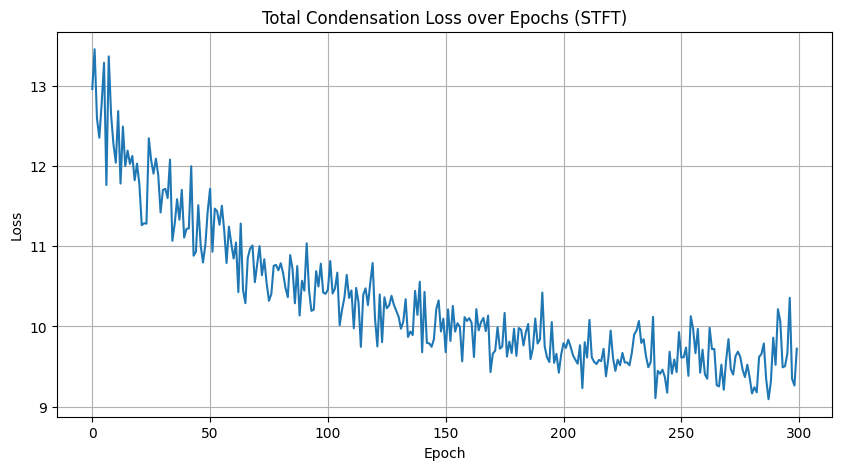

In [8]:
from torch.utils.data import TensorDataset, DataLoader
# --- Evaluation Phase (MODIFIED FOR STFT - Ensuring consistent model factory usage) ---
print("\n--- Starting Downstream Evaluation (STFT) ---")

EVAL_TRAIN_EPOCHS = 100
EVAL_LR = 1e-3 
NUM_EVAL_RUNS = 5 

eval_accuracies_S = []
eval_accuracies_T = []

criterion_eval = nn.CrossEntropyLoss()

for run in range(NUM_EVAL_RUNS):
    print(f"\nEvaluation Run {run + 1}/{NUM_EVAL_RUNS}")
    
    # --- Prepare T_data_tensor for DataLoader (for training on Full T) ---
    T_dataset = TensorDataset(T_data_tensor, T_labels_tensor)
    T_dataloader = DataLoader(T_dataset, batch_size=64, shuffle=True)

    # --- 1. Evaluate Model trained on Condensed S (requires STFT input for evaluation) ---
    # Convert Ttest_data_tensor to STFT magnitude for evaluation
    Ttest_data_spec = torch.stft(
        Ttest_data_tensor.squeeze(-1),
        n_fft=STFT_N_FFT, 
        hop_length=STFT_HOP_LENGTH, 
        win_length=STFT_WIN_LENGTH,
        return_complex=True
    )
    # Reshape for SmallCNN input (batch, time_frames, freq_bins)
    Ttest_data_spec_input = torch.abs(Ttest_data_spec).permute(0, 2, 1)

    eval_model_S = model_factory_freq().to(device) # The S-trained model uses freq-adapted model
    optimizer_eval_S = optim.Adam(eval_model_S.parameters(), lr=EVAL_LR) 

    eval_model_S.train()
    for epoch_eval in tqdm(range(EVAL_TRAIN_EPOCHS), desc=f"Train S (Run {run+1})"):
        optimizer_eval_S.zero_grad()
        # Train on a *fixed view* from S during downstream eval. Which view?
        # Typically, a single time-domain model, or a single frequency-domain model
        # The paper doesn't clarify how evaluation happens after dual-domain training for the 'optimal' model.
        # Let's train the downstream model on the STFT representation of S for a consistent comparison with its training method.
        # So we need to compute STFT of S as well for the evaluation training loop.
        S_spec = torch.stft(
            S.squeeze(-1), 
            n_fft=STFT_N_FFT, hop_length=STFT_HOP_LENGTH, win_length=STFT_WIN_LENGTH, return_complex=True
        )
        S_spec_input = torch.abs(S_spec).permute(0, 2, 1)

        outputs = eval_model_S(S_spec_input)
        loss = criterion_eval(outputs, y_S)
        loss.backward()
        optimizer_eval_S.step()

    eval_model_S.eval()
    correct_S = 0
    total_S = 0
    with torch.no_grad():
        outputs = eval_model_S(Ttest_data_spec_input) # Evaluate on STFT of Ttest
        _, predicted = torch.max(outputs.data, 1)
        total_S += Ttest_labels_tensor.size(0)
        correct_S += (predicted == Ttest_labels_tensor).sum().item()
    accuracy_S = 100 * correct_S / total_S
    eval_accuracies_S.append(accuracy_S)
    print(f"Accuracy on T_test (from Cond-S trained on STFT): {accuracy_S:.2f}%")

    # --- 2. Evaluate Model trained on Full T (Baseline - also with STFT for consistency) ---
    eval_model_T = model_factory_freq().to(device) # Consistent model for full T
    optimizer_eval_T = optim.Adam(eval_model_T.parameters(), lr=EVAL_LR)

    eval_model_T.train()
    for epoch_eval in tqdm(range(EVAL_TRAIN_EPOCHS), desc=f"Train T (Run {run+1})"):
        for batch_X, batch_y in T_dataloader:
            # Convert batch_X to STFT for training
            batch_X_spec = torch.stft(
                batch_X.squeeze(-1), 
                n_fft=STFT_N_FFT, hop_length=STFT_HOP_LENGTH, win_length=STFT_WIN_LENGTH, return_complex=True
            )
            batch_X_spec_input = torch.abs(batch_X_spec).permute(0, 2, 1)

            optimizer_eval_T.zero_grad()
            outputs = eval_model_T(batch_X_spec_input)
            loss = criterion_eval(outputs, batch_y)
            loss.backward()
            optimizer_eval_T.step()
    
    eval_model_T.eval()
    correct_T = 0
    total_T = 0
    with torch.no_grad():
        outputs = eval_model_T(Ttest_data_spec_input) # Evaluate on STFT of Ttest
        _, predicted = torch.max(outputs.data, 1)
        total_T += Ttest_labels_tensor.size(0)
        correct_T += (predicted == Ttest_labels_tensor).sum().item()
    accuracy_T = 100 * correct_T / total_T
    eval_accuracies_T.append(accuracy_T)
    print(f"Accuracy on T_test (from Full T trained on STFT): {accuracy_T:.2f}%")


print("\n--- Summary of Results (STFT) ---")
print(f"Accuracy from Cond-S (STFT): Mean={np.mean(eval_accuracies_S):.2f}%, Std={np.std(eval_accuracies_S):.2f}%")
print(f"Accuracy from Full T (STFT): Mean={np.mean(eval_accuracies_T):.2f}%, Std={np.std(eval_accuracies_T):.2f}%")

# Optional: Plot condensation loss over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(condensation_losses)
plt.title("Total Condensation Loss over Epochs (STFT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()